In [1]:
import Diagrams.Backend.Cairo.CmdLine

In [7]:
{-# LANGUAGE NoMonomorphismRestriction FlexibleContexts #-}
import Diagrams.Prelude
import Data.List
import Data.Ord (comparing)
import Data.Function (on)
import Data.Maybe (fromMaybe)
import Data.Colour.SRGB (sRGB24read)

colors = map sRGB24read["#000000", "#D1DBBD", "#91AA9D", "#3E606F", "#193441", "#000000"]

A subset is represented by the size of the parent set paired with the
list of elements in the subset.  `isSubset` tests whether one set is a
subset of another; `subsetsBySize` lists all the subsets of a set of
size `n`, grouped according to size.



In [8]:
data Subset = Subset Int [Int]

(Subset _ elts1) `isSubset` (Subset _ elts2) = all (`elem` elts2) elts1

subsetsBySize :: Int -> [[Subset]]
subsetsBySize n = map (map (Subset n))
                . groupBy ((==) `on` length)
                . sortBy (comparing length)
                . subsequences
                $ [1..n]


Line 8: Use sortOn
Found:
sortBy (comparing length)
Why not:
sortOn length

Draw the elements of a subset, by drawing a colored square for each
element present, and leaving a blank space for absent elements.



In [13]:
drawElts :: Int -> [Int] -> Diagram B
drawElts n elts = hcat
                . map (\i -> if i `elem` elts
                               then drawElt i
                               else strutX 1
                      )
                $ [1..n]

drawElt :: Int -> Diagram B
drawElt e = unitSquare # fc (colors !! e) # lw thin

Draw a subset by drawing a dashed rectangle around the elements.  Note
that we also assign a name to the rectangle, corresponding to the
elements it contains, which we use to draw connections between subsets
later.



In [15]:
drawSet (Subset n elts) = (    drawElts n elts # centerXY
                            <> rect (fromIntegral n + 0.5) 1.5
                                 # dashingG [0.2,0.2] 0
                                 # lw thin
                                 # named elts
                          )

Line 1: Redundant bracket
Found:
(drawElts n elts # centerXY
   <>
     rect (fromIntegral n + 0.5) 1.5 # dashingG [0.2, 0.2] 0 # lw thin
       # named elts)
Why not:
drawElts n elts # centerXY
  <>
    rect (fromIntegral n + 0.5) 1.5 # dashingG [0.2, 0.2] 0 # lw thin
      # named elts

Draw a Hasse diagram by drawing subsets grouped by size in rows, and
connecting each set to its subsets in the row below.  [See the user
manual](http://projects.haskell.org/diagrams/manual/diagrams-manual.html#named-subdiagrams)
for a more in-depth explanation of how names are used to connect subsets.



To generate all the connections, we apply `connectSome` to each pair
of adjacent rows, which calls `connect` on those pairs where one is a
subset of the other.



Connect two subsets by looking up the subdiagrams named with their
elements, and drawing a line from the upper boundary of one to the
lower boundary of the other.



In [19]:
hasseRow = centerX . hcat' (with & sep .~ 2) . map drawSet

hasseDiagram n = setsD # drawConnections # centerXY
  where setsD = vcat' (with & sep .~ fromIntegral n)
              . map hasseRow
              . reverse
              $ subsets
        subsets = subsetsBySize n
        drawConnections = applyAll connections


        connections = concat $ zipWith connectSome subsets (tail subsets)
        connectSome subs1 subs2 = [ connect s1 s2 | s1 <- subs1
                                                  , s2 <- subs2
                                                  , s1 `isSubset` s2 ]


        connect (Subset _ elts1) (Subset _ elts2) =
          withNames [elts1, elts2] $ \[b1, b2] ->
            beneath ((boundaryFrom b1 unitY ~~ boundaryFrom b2 unit_Y) # lw thin)

example = pad 1.1 $ hasseDiagram 4

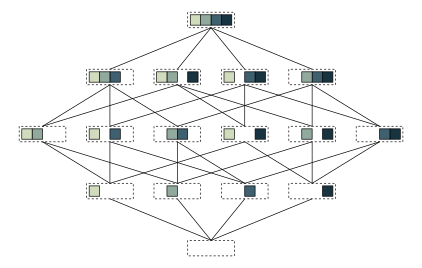

In [20]:
diagram example